# 1. Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Import Library

In [4]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 51.5 MB/s eta 0:00:00


In [5]:
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import gensim

from nltk.stem.snowball import SnowballStemmer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

# 3. Download Resource NLTK

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# A. LDA TOPIC MODELLING (Tweet)

# 4. Load Dataset Tweet

In [7]:
def load_dataset(path):
    acc_names, tweets = [], []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            acc, tweet = line.strip().split('###')
            acc_names.append(acc)
            tweets.append(tweet)
    return acc_names, tweets

path_tweet = "/content/drive/My Drive/Colab Notebooks/SistemTemuKembaliInformasi/Minggu13/twitter.txt"
acc_names, tweets = load_dataset(path_tweet)

# 5. Preprocessing Teks

In [8]:
stemmer = SnowballStemmer("english")
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):
    tokens = text.lower().split()
    tokens = [w for w in tokens if w.isalpha() and w not in stopwords]
    return [stemmer.stem(w) for w in tokens]

tweets_clean = [preprocess(t) for t in tweets]

# 6. Dictionary & Corpus

In [9]:
dictionary = Dictionary(tweets_clean)
dictionary.filter_extremes(no_below=2, no_above=0.9)

corpus = [dictionary.doc2bow(t) for t in tweets_clean]

# 7. Train Model LDA

In [10]:
NUM_TOPICS = 4

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    iterations=400,
    random_state=42
)

# 8. Tampilkan Topik

In [11]:
for idx, topic in lda_model.show_topics(formatted=False):
    print(f"Topic {idx+1}")
    for word, prob in topic:
        print(word, round(prob,4))
    print("-"*40)

Topic 1
catalunya 0.1055
samsung 0.1053
galaxi 0.1053
referendum 0.0856
note 0.0855
block 0.0454
support 0.0454
main 0.0453
full 0.0254
year 0.0254
----------------------------------------
Topic 2
leagu 0.0702
champion 0.0688
catalan 0.0688
leav 0.0686
independ 0.068
referendum 0.0399
spanish 0.0385
block 0.0382
good 0.0382
ban 0.0381
----------------------------------------
Topic 3
iphon 0.0963
referendum 0.0665
leagu 0.056
champion 0.0559
samsung 0.0559
catalunya 0.0559
galaxi 0.0454
catalan 0.0453
note 0.0241
premier 0.0239
----------------------------------------
Topic 4
champion 0.1243
leagu 0.1035
year 0.0642
referendum 0.0458
iphon 0.0456
full 0.0447
play 0.0444
watch 0.0442
win 0.0439
stop 0.0249
----------------------------------------


# 9. Clustering Dokumen

In [12]:
doc_vectors = np.array([
    [prob for _, prob in lda_model.get_document_topics(dictionary.doc2bow(t))]
    for t in tweets_clean
])

kmeans = KMeans(n_clusters=NUM_TOPICS, random_state=42)
clusters = kmeans.fit_predict(doc_vectors)

# 10. Visualisasi Clustering

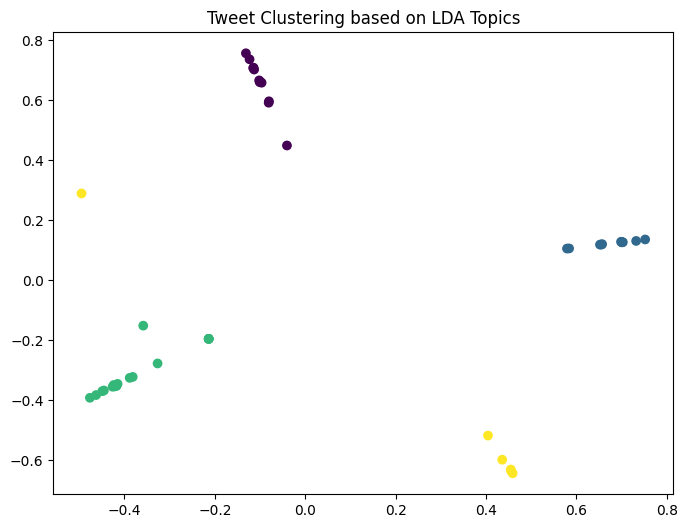

In [13]:
mds = MDS(n_components=2, random_state=42)
positions = mds.fit_transform(doc_vectors)

plt.figure(figsize=(8,6))
plt.scatter(positions[:,0], positions[:,1], c=clusters)
plt.title("Tweet Clustering based on LDA Topics")
plt.show()

# B. TOPIC MODELLING + COHERENCE

# 11. Load Dataset CSV

In [16]:
path_csv = "/content/drive/My Drive/Colab Notebooks/SistemTemuKembaliInformasi/Minggu13/clean_dataset_part01.csv"
df = pd.read_csv(path_csv, sep=";")

texts = df['ProcessedText'].astype(str).tolist()

# 12. Tokenisasi

In [17]:
from gensim.utils import simple_preprocess

tokens = [simple_preprocess(text) for text in texts]

# 13. Dictionary & Corpus

In [18]:
dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(t) for t in tokens]

# 14. Evaluasi Jumlah Topik (Coherence)

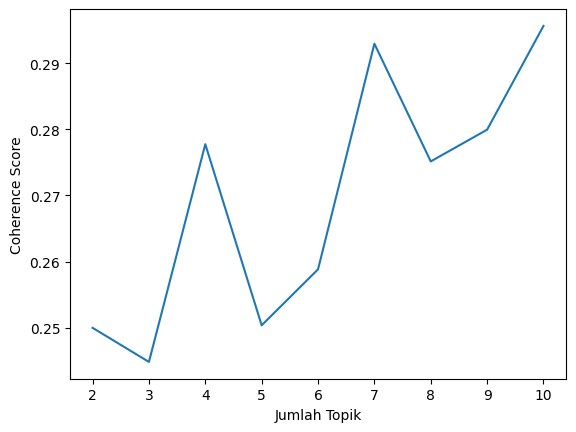

In [19]:
from gensim.models.coherencemodel import CoherenceModel

coherence_scores = []
topic_range = range(2,11)

for k in topic_range:
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k)
    coherence = CoherenceModel(
        model=model,
        texts=tokens,
        dictionary=dictionary,
        coherence='c_v'
    ).get_coherence()
    coherence_scores.append(coherence)

plt.plot(topic_range, coherence_scores)
plt.xlabel("Jumlah Topik")
plt.ylabel("Coherence Score")
plt.show()

# 15. Model Final

In [20]:
final_lda = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=8,
    random_state=42
)

final_lda.print_topics()

[(0,
  '0.047*"covid" + 0.042*"number" + 0.025*"allcaps" + 0.015*"bantu" + 0.010*"iya" + 0.006*"medis" + 0.006*"moga" + 0.006*"repeated" + 0.005*"orang" + 0.005*"tangan"'),
 (1,
  '0.068*"allcaps" + 0.060*"number" + 0.053*"covid" + 0.016*"repeated" + 0.008*"iya" + 0.007*"moga" + 0.007*"masyarakat" + 0.006*"virus" + 0.006*"corona" + 0.005*"tolak"'),
 (2,
  '0.034*"covid" + 0.029*"number" + 0.025*"repeated" + 0.016*"allcaps" + 0.010*"rumah" + 0.007*"mati" + 0.006*"virus" + 0.005*"sebar" + 0.005*"cinta" + 0.005*"perintah"'),
 (3,
  '0.083*"number" + 0.044*"covid" + 0.022*"allcaps" + 0.016*"repeated" + 0.016*"orang" + 0.008*"rumah" + 0.006*"pasien" + 0.005*"iya" + 0.005*"sakit" + 0.004*"positif"'),
 (4,
  '0.048*"covid" + 0.026*"number" + 0.021*"allcaps" + 0.013*"orang" + 0.010*"repeated" + 0.008*"kena" + 0.005*"pandemi" + 0.005*"indonesia" + 0.004*"tangan" + 0.004*"rumah"'),
 (5,
  '0.029*"covid" + 0.025*"number" + 0.009*"allcaps" + 0.009*"dampak" + 0.009*"mandi" + 0.006*"virus" + 0.006*"

# 16. Dominant Topic per Dokumen

In [21]:
dominant_topics = []

for doc in corpus:
    topic_probs = sorted(final_lda[doc], key=lambda x: x[1], reverse=True)
    dominant_topics.append(topic_probs[0][0])

df['Dominant_Topic'] = dominant_topics
df.head()

,Unnamed: 0,Tweet,Sentimen,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText,Dominant_Topic
0,0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,emang lemes bgt ya mulut lu gue yg mau beli be...,"['emang', 'lemes', 'bgt', 'ya', 'mulut', 'lu',...","['memang', 'lemes', 'banget', 'iya', 'mulut', ...","['lemes', 'banget', 'iya', 'mulut', 'beli', 'b...",lemes banget iya mulut beli beli obat mikirr d...,lemes banget iya mulut beli beli obat mikirr d...,3
1,1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"['cegah', 'mata', 'rantai', 'covid', 'number',...","['cegah', 'mata', 'rantai', 'covid', 'number',...","['cegah', 'mata', 'rantai', 'covid', 'number',...",cegah mata rantai covid number mari dirumah mi...,cegah mata rantai covid number mari rumah ming...,7
2,2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"['aku', 'mohon', 'yaallah', 'semoga', 'wabah',...","['aku', 'mohon', 'yaallah', 'semoga', 'wabah',...","['mohon', 'yaallah', 'semoga', 'wabah', 'covid...",mohon yaallah semoga wabah covid number menghi...,mohon yaallah moga wabah covid number hilang r...,7
3,3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"['pemprov', 'papua', 'naikkan', 'status', 'jad...","['pemprov', 'papua', 'naikkan', 'status', 'jad...","['pemprov', 'papua', 'naikkan', 'status', 'tan...",pemprov papua naikkan status tanggap darurat c...,pemprov papua naik status tanggap darurat covi...,7
4,4,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"['covid', 'belum', 'nyampe', 'prigen', 'mbak',...","['covid', 'belum', 'nyampe', 'prigen', 'mbak',...","['covid', 'nyampe', 'prigen', 'mbak', 'aduh', ...",covid nyampe prigen mbak aduh bohong,covid nyampe prigen mbak aduh bohong,4


# 17. Kesimpulan

### Dari hasil Topic Modelling menggunakan LDA, setiap tweet berhasil dikelompokkan ke dalam satu topik utama (Dominant Topic) yang paling sesuai dengan isi kalimatnya. Tweet dengan kata dan konteks yang mirip cenderung masuk ke topik yang sama, sehingga model dapat membantu memahami tema utama yang sedang dibahas dalam kumpulan data tweet.

###